In [1]:
import numpy as np
import csv
import pandas as pd

from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline


def generate_csv(data, title, str_path):
    save_file = ""
    if(title == "actions"):
        save_file = str_path
    elif(title == "obs"):
        save_file = str_path
    
    np.savetxt(save_file, data, delimiter=",")
    all_filenames.append(save_file)
    
    with open(save_file,newline='') as f:
        r = csv.reader(f)
        row_data = [line for line in r]
        
    if(title == "actions"):
        with open(save_file,'w',newline='') as f:
            w = csv.writer(f)
            w.writerow(['act_arm_one', 'act_arm_two', 'act_arm_three', 'act_arm_four', 'act_arm_five', 'act_arm_six', 'act_arm_seven',
                       'act_finger_lt0', 'act_finger_rg0', 'act_finger_md0',
                       'act_finger_if0', 'act_finger_if1', 'act_finger_if2',
                       'act_finger_tb0', 'act_finger_tb1', 'act_finger_tb2'])
            
            w.writerows(row_data)
            return save_file
    elif(title == "obs"):
         with open(save_file,'w',newline='') as f:
            w = csv.writer(f)
            w.writerow(['arm_one', 'arm_two', 'arm_three', 'arm_four', 'arm_five', 'arm_six', 'arm_seven', 
                        'drink_x', 'drink_y', 'drink_z',
                        'hand_x', 'hand_y', 'hand_z', 
                        'finger_lt0', 'finger_rg0', 'finger_md0',
                        'finger_if0', 'finger_if1', 'finger_if2',
                        'finger_tb0', 'finger_tb1', 'finger_tb2'])
            
            w.writerows(row_data)
            return save_file
            
def merge_csv(obs_path, action_path, save_path):

    a = pd.read_csv(obs_path)
    b = pd.read_csv(action_path)
    result = pd.concat([a, b], axis=1)
    result.to_csv(save_path, index=False)


Using TensorFlow backend.


In [2]:
def readTrain(file_path):
    train = pd.read_csv(file_path)
    print(train)
    print(train.shape)
    return train

def augDataRow(train, timestep):
    zero_row = train.loc[0]
    final_row = train.loc[train.shape[0]-1]
    df = pd.DataFrame([zero_row],columns=['arm_one', 'arm_two', 'arm_three', 'arm_four', 'arm_five', 'arm_six', 'arm_seven', 
                                          'drink_x', 'drink_y', 'drink_z',
                                          'hand_x', 'hand_y', 'hand_z', 
                                          'finger_lt0', 'finger_rg0', 'finger_md0',
                                          'finger_if0', 'finger_if1', 'finger_if2',
                                          'finger_tb0', 'finger_tb1', 'finger_tb2',
                                          'act_arm_one', 'act_arm_two', 'act_arm_three', 'act_arm_four', 'act_arm_five', 'act_arm_six', 'act_arm_seven',
                                          'act_finger_lt0', 'act_finger_rg0', 'act_finger_md0',
                                          'act_finger_if0', 'act_finger_if1', 'act_finger_if2',
                                          'act_finger_tb0', 'act_finger_tb1', 'act_finger_tb2'])
                                          
    
    df_final = pd.DataFrame([final_row],columns=['arm_one', 'arm_two', 'arm_three', 'arm_four', 'arm_five', 'arm_six', 'arm_seven', 
                                                 'drink_x', 'drink_y', 'drink_z',
                                                 'hand_x', 'hand_y', 'hand_z', 
                                                 'finger_lt0', 'finger_rg0', 'finger_md0',
                                                 'finger_if0', 'finger_if1', 'finger_if2',
                                                 'finger_tb0', 'finger_tb1', 'finger_tb2',
                                                 'act_arm_one', 'act_arm_two', 'act_arm_three', 'act_arm_four', 'act_arm_five', 'act_arm_six', 'act_arm_seven',
                                                 'act_finger_lt0', 'act_finger_rg0', 'act_finger_md0',
                                                 'act_finger_if0', 'act_finger_if1', 'act_finger_if2',
                                                 'act_finger_tb0', 'act_finger_tb1', 'act_finger_tb2'])
    
    for i in range(timestep-1):
        train = pd.concat([df,train], ignore_index = True)
        
    for i in range(timestep-1):
        train = pd.concat([train,df_final], ignore_index = True)
        
    print(type(train))
    print(train.shape)   
    print(train)
    return train

hand_x_max_arr = []
hand_x_min_arr = []
hand_y_max_arr = []
hand_y_min_arr = []
hand_z_max_arr = []
hand_z_min_arr = []

def hand_pos(train):
    hand_x_max = -1000.0
    hand_x_min = 1000.0
    for i in range(train['hand_x'].shape[0]):
        if(train['hand_x'][i] > hand_x_max):
            hand_x_max = train['hand_x'][i]
    for i in range(train['hand_x'].shape[0]):
        if(train['hand_x'][i] < hand_x_min):
            hand_x_min = train['hand_x'][i]
    
    print("hand_x max is : " + str(hand_x_max))
    hand_x_max_arr.append(hand_x_max)
    print("hand_x min is : " + str(hand_x_min))
    hand_x_min_arr.append(hand_x_min)
    
    hand_y_max = -1000.0
    hand_y_min = 1000.0
    for i in range(train['hand_y'].shape[0]):
#         print(train['hand_y'][i])
        if(train['hand_y'][i] > hand_y_max):
            hand_y_max = train['hand_y'][i]
    for i in range(train['hand_y'].shape[0]):
        if(train['hand_y'][i] < hand_y_min):
            hand_y_min = train['hand_y'][i]
    
    print("hand_y max is : " + str(hand_y_max))
    hand_y_max_arr.append(hand_y_max)
    print("hand_y min is : " + str(hand_y_min))
    hand_y_min_arr.append(hand_y_min)
    
     
    hand_z_max = -1000.0
    hand_z_min = 1000.0
    for i in range(train['hand_z'].shape[0]):
#         print(train['hand_z'][i])
        if(train['hand_z'][i] > hand_z_max):
            hand_z_max = train['hand_z'][i]
    for i in range(train['hand_z'].shape[0]):
        if(train['hand_z'][i] < hand_z_min):
            hand_z_min = train['hand_z'][i]
    
    print("hand_z max is : " + str(hand_z_max))
    hand_z_max_arr.append(hand_z_max)
    print("hand_z min is : " + str(hand_z_min))
    hand_z_min_arr.append(hand_z_min)

###for many dataset
def many_normalize(train):
    max_x = 0.95
    min_x = 0.65
    max_z = 0.3
    min_z = 0.0
    
    train = train.drop(['drink_y'], axis=1)
    train['drink_x'] = (train['drink_x'] - min_x)/(max_x - min_x)
#    train['drink_y'] = (train['drink_y'] - train['drink_y'].min())/(train['drink_y'].max() - train['drink_y'].min())
    train['drink_z'] = (train['drink_z'] - min_z)/(max_z - min_z)
    
    hand_x_max = -1000.0
    hand_x_min = 1000.0
    hand_y_max = -1000.0
    hand_y_min = 1000.0
    hand_z_max = -1000.0
    hand_z_min = 1000.0
    
    for i in range(len(hand_x_max_arr)):
        if(hand_x_max_arr[i] > hand_x_max):
            hand_x_max = hand_x_max_arr[i]
    for i in range(len(hand_x_min_arr)):
        if(hand_x_min_arr[i] < hand_x_min):
            hand_x_min = hand_x_min_arr[i]
            
    
    for i in range(len(hand_y_max_arr)):
        if(hand_y_max_arr[i] > hand_y_max):
            hand_y_max = hand_y_max_arr[i]
    for i in range(len(hand_y_min_arr)):
        if(hand_y_min_arr[i] < hand_y_min):
            hand_y_min = hand_y_min_arr[i]
            
    for i in range(len(hand_z_max_arr)):
        if(hand_z_max_arr[i] > hand_z_max):
            hand_z_max = hand_z_max_arr[i]
    for i in range(len(hand_z_min_arr)):
        if(hand_z_min_arr[i] < hand_z_min):
            hand_z_min = hand_z_min_arr[i]
            
    print("hand_x_max_arr is : " )
    print(hand_x_max_arr)
    print(hand_x_max)
    print("hand_x_min_arr is : " )
    print(hand_x_min_arr)
    print(hand_x_min)
    print("hand_y_max_arr is : " )
    print(hand_y_max_arr)
    print(hand_y_max)
    print("hand_y_min_arr is : " )
    print(hand_y_min_arr)
    print(hand_y_min)
    print("hand_z_max_arr is : " )
    print(hand_z_max_arr)
    print(hand_z_max)
    print("hand_z_min_arr is : " )
    print(hand_z_min_arr)
    print(hand_z_min)

    train['hand_x'] = (train['hand_x'] - hand_x_min)/(hand_x_max - hand_x_min)
    train['hand_y'] = (train['hand_y'] - hand_y_min)/(hand_y_max - hand_y_min)
    train['hand_z'] = (train['hand_z'] - hand_z_min)/(hand_z_max - hand_z_min)
     
    return train

"""
def DF_Col_Max_Min(train, column_name):
    
    max_value = -1000.0
    min_value = 1000.0
    
    for i in range(train[column_name].shape[0]):
        if(train[column_name][i] > max_value):
            max_value = train[column_name][i]
            
    for i in range(train[column_name].shape[0]):
        if(train[column_name][i] < min_value):
            min_value = train[column_name][i]
    
    return max_value, min_value
"""
###for one dataset
def normalize(train):
    #in dataset 0->8 : max_x = 0.9 min_x = 0.7 / max_y = min_y=0.82 / max_z = 0.25 min_z = 0.05 

    max_x = 0.95
    min_x = 0.65
    max_z = 0.3
    min_z = 0.0
    
    train = train.drop(['drink_y'], axis=1)
    train['drink_x'] = (train['drink_x'] - min_x)/(max_x - min_x)
#    train['drink_y'] = (train['drink_y'] - train['drink_y'].min())/(train['drink_y'].max() - train['drink_y'].min())
    train['drink_z'] = (train['drink_z'] - min_z)/(max_z - min_z)
    
    hand_x_max = -1000.0
    hand_x_min = 1000.0
    for i in range(train['hand_x'].shape[0]):
#         print(train['hand_x'][i])
        if(train['hand_x'][i] > hand_x_max):
            hand_x_max = train['hand_x'][i]
    for i in range(train['hand_x'].shape[0]):
        if(train['hand_x'][i] < hand_x_min):
            hand_x_min = train['hand_x'][i]
    
    print("hand_x max is : " + str(hand_x_max))
    print("hand_x min is : " + str(hand_x_min))
    
    hand_y_max = -1000.0
    hand_y_min = 1000.0
    for i in range(train['hand_y'].shape[0]):
#         print(train['hand_y'][i])
        if(train['hand_y'][i] > hand_y_max):
            hand_y_max = train['hand_y'][i]
    for i in range(train['hand_y'].shape[0]):
        if(train['hand_y'][i] < hand_y_min):
            hand_y_min = train['hand_y'][i]
    
    print("hand_y max is : " + str(hand_y_max))
    print("hand_y min is : " + str(hand_y_min))
    
    hand_z_max = -1000.0
    hand_z_min = 1000.0
    for i in range(train['hand_z'].shape[0]):
#         print(train['hand_z'][i])
        if(train['hand_z'][i] > hand_z_max):
            hand_z_max = train['hand_z'][i]
    for i in range(train['hand_z'].shape[0]):
        if(train['hand_z'][i] < hand_z_min):
            hand_z_min = train['hand_z'][i]
    
    print("hand_z max is : " + str(hand_z_max))
    print("hand_z min is : " + str(hand_z_min))

#     train['hand_x'] = (train['hand_x'] - train['hand_x'].min())/(train['hand_x'].max() - train['hand_x'].min())
#     train['hand_y'] = (train['hand_y'] - train['hand_y'].min())/(train['hand_y'].max() - train['hand_y'].min())
#     train['hand_z'] = (train['hand_z'] - train['hand_z'].min())/(train['hand_z'].max() - train['hand_z'].min())
      
    train['hand_x'] = (train['hand_x'] - hand_x_min)/(hand_x_max - hand_x_min)
    train['hand_y'] = (train['hand_y'] - hand_y_min)/(hand_y_max - hand_y_min)
    train['hand_z'] = (train['hand_z'] - hand_z_min)/(hand_z_max - hand_z_min)
     

    return train

def buildTrain_v2(train, timesteps):
    X_train, Y_train = [], []
    print(type(train))
    #original is 12 
    #plus 9 hand andgle
    train_split = np.split(train, [21], axis=1)
    X_train = train_split[0]
    Y_train = train_split[1]
    X_train_new = []
    Y_train_new = []
    
    print(Y_train)
    print(type(Y_train))
    print(Y_train.shape)
    
    timesteps = timesteps-1
    for i in range(train.shape[0] - timesteps):
#         print("now i is : " + str(i))
#         print(np.array(X_train.loc[i:i+timesteps]))
        X_train_new.append(np.array(X_train.loc[i:i+timesteps]))
    
    Y_train_new = np.array(Y_train.loc[0+timesteps:Y_train.shape[0]-1])   
              
    return np.array(X_train_new), Y_train_new


def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]


def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

def buildManyToOneModel(X_train):
    model = Sequential()
    ##many to many
    #model.add(LSTM(units = 64, return_sequences = True, input_shape = (1, X_train.shape[-1])))
    ##many to many
    model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
    model.summary()

    return model


def buildManyToOneModel_expand_depth(X_train):
    model = Sequential()
    ##many to many
    #model.add(LSTM(units = 64, return_sequences = True, input_shape = (1, X_train.shape[-1])))
    ##many to many
    model.add(LSTM(units = 512, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 128))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
    model.summary()

    return model

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 512)            1093632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Instructions 

201/201 [==============================] - 0s 511us/step - loss: 0.0042
Epoch 67/500
201/201 [==============================] - 0s 481us/step - loss: 0.0030
Epoch 68/500
201/201 [==============================] - 0s 501us/step - loss: 0.0026
Epoch 69/500
201/201 [==============================] - 0s 643us/step - loss: 0.0041
Epoch 70/500
201/201 [==============================] - 0s 605us/step - loss: 0.0041
Epoch 71/500
201/201 [==============================] - 0s 526us/step - loss: 0.0035
Epoch 72/500
201/201 [==============================] - 0s 541us/step - loss: 0.0033
Epoch 73/500
201/201 [==============================] - 0s 660us/step - loss: 0.0026
Epoch 74/500
201/201 [==============================] - 0s 541us/step - loss: 0.0055
Epoch 75/500
201/201 [==============================] - 0s 496us/step - loss: 0.0028
Epoch 76/500
201/201 [==============================] - 0s 491us/step - loss: 0.0025
Epoch 77/500
201/201 [==============================] - 0s 501us/step - loss: 

201/201 [==============================] - 0s 494us/step - loss: 0.0020
Epoch 162/500
201/201 [==============================] - 0s 734us/step - loss: 0.0014
Epoch 163/500
201/201 [==============================] - 0s 584us/step - loss: 0.0016
Epoch 164/500
201/201 [==============================] - 0s 546us/step - loss: 0.0017
Epoch 165/500
201/201 [==============================] - 0s 620us/step - loss: 0.0014
Epoch 166/500
201/201 [==============================] - 0s 521us/step - loss: 0.0017
Epoch 167/500
201/201 [==============================] - 0s 665us/step - loss: 0.0015
Epoch 168/500
201/201 [==============================] - 0s 526us/step - loss: 0.0022
Epoch 169/500
201/201 [==============================] - 0s 586us/step - loss: 0.0014
Epoch 170/500
201/201 [==============================] - 0s 533us/step - loss: 0.0016
Epoch 171/500
201/201 [==============================] - 0s 610us/step - loss: 0.0016
Epoch 172/500
201/201 [==============================] - 0s 486us/st

201/201 [==============================] - 0s 618us/step - loss: 0.0011
Epoch 257/500
201/201 [==============================] - 0s 576us/step - loss: 0.0015
Epoch 258/500
201/201 [==============================] - 0s 643us/step - loss: 0.0012
Epoch 259/500
201/201 [==============================] - 0s 567us/step - loss: 9.6127e-04
Epoch 260/500
201/201 [==============================] - 0s 576us/step - loss: 8.9248e-04
Epoch 261/500
201/201 [==============================] - 0s 536us/step - loss: 0.0011
Epoch 262/500
201/201 [==============================] - 0s 807us/step - loss: 0.0011
Epoch 263/500
201/201 [==============================] - 0s 566us/step - loss: 0.0012
Epoch 264/500
201/201 [==============================] - 0s 496us/step - loss: 8.4746e-04
Epoch 265/500
201/201 [==============================] - 0s 536us/step - loss: 0.0012
Epoch 266/500
201/201 [==============================] - 0s 546us/step - loss: 8.6834e-04
Epoch 267/500
201/201 [=============================

201/201 [==============================] - 0s 556us/step - loss: 9.2476e-04
Epoch 349/500
201/201 [==============================] - 0s 506us/step - loss: 7.5403e-04
Epoch 350/500
201/201 [==============================] - 0s 581us/step - loss: 6.7633e-04
Epoch 351/500
201/201 [==============================] - 0s 521us/step - loss: 9.1677e-04
Epoch 352/500
201/201 [==============================] - 0s 486us/step - loss: 6.5091e-04
Epoch 353/500
201/201 [==============================] - 0s 578us/step - loss: 8.6603e-04
Epoch 354/500
201/201 [==============================] - 0s 516us/step - loss: 0.0010
Epoch 355/500
201/201 [==============================] - 0s 536us/step - loss: 7.9842e-04
Epoch 356/500
201/201 [==============================] - 0s 595us/step - loss: 9.3196e-04
Epoch 357/500
201/201 [==============================] - 0s 521us/step - loss: 7.9985e-04
Epoch 358/500
201/201 [==============================] - 0s 546us/step - loss: 7.5011e-04
Epoch 359/500
201/201 [=====

201/201 [==============================] - 0s 600us/step - loss: 7.7747e-04
Epoch 440/500
201/201 [==============================] - 0s 590us/step - loss: 6.9917e-04
Epoch 441/500
201/201 [==============================] - 0s 526us/step - loss: 5.4032e-04
Epoch 442/500
201/201 [==============================] - 0s 551us/step - loss: 7.1634e-04
Epoch 443/500
201/201 [==============================] - 0s 551us/step - loss: 8.1392e-04
Epoch 444/500
201/201 [==============================] - 0s 531us/step - loss: 6.9874e-04
Epoch 445/500
201/201 [==============================] - 0s 556us/step - loss: 5.7186e-04
Epoch 446/500
201/201 [==============================] - 0s 496us/step - loss: 8.1439e-04
Epoch 447/500
201/201 [==============================] - 0s 581us/step - loss: 6.4848e-04
Epoch 448/500
201/201 [==============================] - 0s 499us/step - loss: 7.0774e-04
Epoch 449/500
201/201 [==============================] - 0s 536us/step - loss: 6.0452e-04
Epoch 450/500
201/201 [=

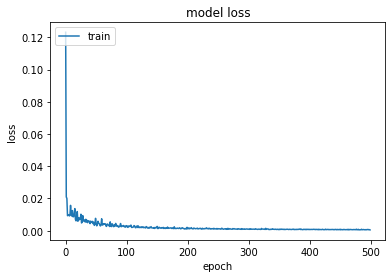

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 512)           1093632   
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
206/206 [==============================] - 2s 9ms/step - loss: 0.1238
Epoch 2/500
206/206 [=============================

206/206 [==============================] - 0s 792us/step - loss: 0.0042
Epoch 86/500
206/206 [==============================] - 0s 794us/step - loss: 0.0031
Epoch 87/500
206/206 [==============================] - 0s 779us/step - loss: 0.0039
Epoch 88/500
206/206 [==============================] - 0s 881us/step - loss: 0.0026
Epoch 89/500
206/206 [==============================] - 0s 881us/step - loss: 0.0019
Epoch 90/500
206/206 [==============================] - 0s 925us/step - loss: 0.0027
Epoch 91/500
206/206 [==============================] - 0s 954us/step - loss: 0.0036
Epoch 92/500
206/206 [==============================] - 0s 991us/step - loss: 0.0026
Epoch 93/500
206/206 [==============================] - 0s 906us/step - loss: 0.0029
Epoch 94/500
206/206 [==============================] - 0s 889us/step - loss: 0.0028
Epoch 95/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 96/500
206/206 [==============================] - 0s 1ms/step - loss: 0.00

206/206 [==============================] - 0s 930us/step - loss: 0.0016
Epoch 181/500
206/206 [==============================] - 0s 949us/step - loss: 0.0019
Epoch 182/500
206/206 [==============================] - 0s 949us/step - loss: 0.0011
Epoch 183/500
206/206 [==============================] - 0s 901us/step - loss: 0.0013
Epoch 184/500
206/206 [==============================] - 0s 961us/step - loss: 0.0016
Epoch 185/500
206/206 [==============================] - 0s 949us/step - loss: 0.0013
Epoch 186/500
206/206 [==============================] - 0s 891us/step - loss: 0.0014
Epoch 187/500
206/206 [==============================] - 0s 961us/step - loss: 0.0015
Epoch 188/500
206/206 [==============================] - 0s 813us/step - loss: 0.0013
Epoch 189/500
206/206 [==============================] - 0s 818us/step - loss: 0.0015
Epoch 190/500
206/206 [==============================] - 0s 816us/step - loss: 0.0015
Epoch 191/500
206/206 [==============================] - 0s 770us/st

206/206 [==============================] - 0s 1ms/step - loss: 7.8362e-04
Epoch 275/500
206/206 [==============================] - 0s 816us/step - loss: 0.0010
Epoch 276/500
206/206 [==============================] - 0s 755us/step - loss: 0.0011
Epoch 277/500
206/206 [==============================] - 0s 809us/step - loss: 8.3276e-04
Epoch 278/500
206/206 [==============================] - 0s 813us/step - loss: 0.0011
Epoch 279/500
206/206 [==============================] - 0s 804us/step - loss: 8.2022e-04
Epoch 280/500
206/206 [==============================] - 0s 876us/step - loss: 0.0013
Epoch 281/500
206/206 [==============================] - 0s 1ms/step - loss: 8.9861e-04
Epoch 282/500
206/206 [==============================] - 0s 750us/step - loss: 0.0010
Epoch 283/500
206/206 [==============================] - 0s 901us/step - loss: 0.0011
Epoch 284/500
206/206 [==============================] - 0s 847us/step - loss: 8.8579e-04
Epoch 285/500
206/206 [=============================

206/206 [==============================] - 0s 872us/step - loss: 6.8931e-04
Epoch 367/500
206/206 [==============================] - 0s 830us/step - loss: 6.9963e-04
Epoch 368/500
206/206 [==============================] - 0s 784us/step - loss: 7.0600e-04
Epoch 369/500
206/206 [==============================] - 0s 804us/step - loss: 8.2176e-04
Epoch 370/500
206/206 [==============================] - 0s 818us/step - loss: 8.9549e-04
Epoch 371/500
206/206 [==============================] - 0s 804us/step - loss: 7.9009e-04
Epoch 372/500
206/206 [==============================] - 0s 813us/step - loss: 6.6556e-04
Epoch 373/500
206/206 [==============================] - 0s 789us/step - loss: 6.0941e-04
Epoch 374/500
206/206 [==============================] - 0s 770us/step - loss: 7.4763e-04
Epoch 375/500
206/206 [==============================] - 0s 816us/step - loss: 9.2943e-04
Epoch 376/500
206/206 [==============================] - 0s 755us/step - loss: 6.6476e-04
Epoch 377/500
206/206 [=

206/206 [==============================] - 0s 973us/step - loss: 6.6964e-04
Epoch 458/500
206/206 [==============================] - 0s 943us/step - loss: 5.8437e-04
Epoch 459/500
206/206 [==============================] - 0s 952us/step - loss: 8.2287e-04
Epoch 460/500
206/206 [==============================] - 0s 881us/step - loss: 6.2858e-04
Epoch 461/500
206/206 [==============================] - 0s 839us/step - loss: 5.3267e-04
Epoch 462/500
206/206 [==============================] - 0s 932us/step - loss: 5.6866e-04
Epoch 463/500
206/206 [==============================] - 0s 818us/step - loss: 5.4061e-04
Epoch 464/500
206/206 [==============================] - 0s 809us/step - loss: 5.1360e-04
Epoch 465/500
206/206 [==============================] - 0s 809us/step - loss: 6.7615e-04
Epoch 466/500
206/206 [==============================] - 0s 808us/step - loss: 6.4688e-04
Epoch 467/500
206/206 [==============================] - 0s 821us/step - loss: 4.6289e-04
Epoch 468/500
206/206 [=

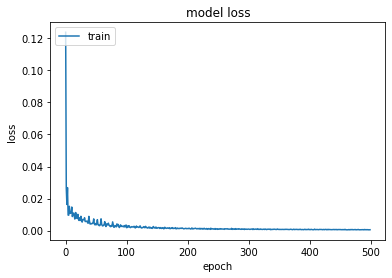

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20, 512)           1093632   
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
216/216 [==============================] - 2s 9ms/step - loss: 0.1387
Epoch 2/500
216/216 [=============================

216/216 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 88/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 89/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 90/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 91/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 92/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 93/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 94/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 95/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 96/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 97/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 98/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 99/500
216/

216/216 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 185/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 186/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 187/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 188/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 189/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 190/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 191/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 192/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 193/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 194/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 195/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 

216/216 [==============================] - 0s 1ms/step - loss: 8.7415e-04
Epoch 281/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 282/500
216/216 [==============================] - 0s 1ms/step - loss: 9.4878e-04
Epoch 283/500
216/216 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 284/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 285/500
216/216 [==============================] - 0s 1ms/step - loss: 9.3087e-04
Epoch 286/500
216/216 [==============================] - 0s 1ms/step - loss: 9.4671e-04
Epoch 287/500
216/216 [==============================] - 0s 1ms/step - loss: 7.3167e-04
Epoch 288/500
216/216 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 289/500
216/216 [==============================] - 0s 1ms/step - loss: 9.3744e-04
Epoch 290/500
216/216 [==============================] - 0s 1ms/step - loss: 9.2771e-04
Epoch 291/500
216/216 [==============================] - 0s 1m

216/216 [==============================] - 0s 1ms/step - loss: 7.1349e-04
Epoch 374/500
216/216 [==============================] - 0s 1ms/step - loss: 6.2570e-04
Epoch 375/500
216/216 [==============================] - 0s 1ms/step - loss: 8.8042e-04
Epoch 376/500
216/216 [==============================] - 0s 1ms/step - loss: 6.9928e-04
Epoch 377/500
216/216 [==============================] - 0s 1ms/step - loss: 7.5518e-04
Epoch 378/500
216/216 [==============================] - 0s 1ms/step - loss: 6.4643e-04
Epoch 379/500
216/216 [==============================] - 0s 1ms/step - loss: 7.9696e-04
Epoch 380/500
216/216 [==============================] - 0s 1ms/step - loss: 6.8748e-04
Epoch 381/500
216/216 [==============================] - 0s 1ms/step - loss: 6.2245e-04
Epoch 382/500
216/216 [==============================] - 0s 1ms/step - loss: 6.9099e-04
Epoch 383/500
216/216 [==============================] - 0s 1ms/step - loss: 7.5973e-04
Epoch 384/500
216/216 [=======================

216/216 [==============================] - 0s 1ms/step - loss: 5.8923e-04
Epoch 467/500
216/216 [==============================] - 0s 1ms/step - loss: 5.7295e-04
Epoch 468/500
216/216 [==============================] - 0s 1ms/step - loss: 5.2461e-04
Epoch 469/500
216/216 [==============================] - 0s 1ms/step - loss: 5.6517e-04
Epoch 470/500
216/216 [==============================] - 0s 1ms/step - loss: 6.3593e-04
Epoch 471/500
216/216 [==============================] - 0s 1ms/step - loss: 6.2563e-04
Epoch 472/500
216/216 [==============================] - 0s 1ms/step - loss: 5.7843e-04
Epoch 473/500
216/216 [==============================] - 0s 1ms/step - loss: 6.2666e-04
Epoch 474/500
216/216 [==============================] - 0s 1ms/step - loss: 5.8352e-04
Epoch 475/500
216/216 [==============================] - 0s 1ms/step - loss: 4.8212e-04
Epoch 476/500
216/216 [==============================] - 0s 1ms/step - loss: 5.6009e-04
Epoch 477/500
216/216 [=======================

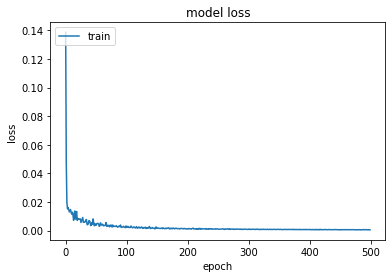

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.

(226, 30, 21)
(226, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 512)           1093632   
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 512)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
226/226 [==============================] - 2s 10ms/step - loss: 0.1483
Epoch 2/500
226/226 [====

226/226 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 88/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 89/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 90/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 91/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 92/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 93/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 94/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 95/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 96/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 97/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 98/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 99/500
226/

226/226 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 185/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 186/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 187/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 188/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 189/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 190/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 191/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 192/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 193/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 194/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 195/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 

226/226 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 281/500
226/226 [==============================] - 0s 2ms/step - loss: 8.8903e-04
Epoch 282/500
226/226 [==============================] - 0s 2ms/step - loss: 7.7191e-04
Epoch 283/500
226/226 [==============================] - 0s 2ms/step - loss: 7.8622e-04
Epoch 284/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 285/500
226/226 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 286/500
226/226 [==============================] - 0s 2ms/step - loss: 8.0370e-04
Epoch 287/500
226/226 [==============================] - 0s 2ms/step - loss: 8.2982e-04
Epoch 288/500
226/226 [==============================] - 0s 2ms/step - loss: 9.0485e-04
Epoch 289/500
226/226 [==============================] - 0s 2ms/step - loss: 9.6694e-04
Epoch 290/500
226/226 [==============================] - 0s 2ms/step - loss: 8.2119e-04
Epoch 291/500
226/226 [==============================] - 0

226/226 [==============================] - 0s 2ms/step - loss: 6.5957e-04
Epoch 374/500
226/226 [==============================] - 0s 2ms/step - loss: 5.8847e-04
Epoch 375/500
226/226 [==============================] - 0s 2ms/step - loss: 7.5916e-04
Epoch 376/500
226/226 [==============================] - 0s 2ms/step - loss: 6.5835e-04
Epoch 377/500
226/226 [==============================] - 0s 2ms/step - loss: 7.0793e-04
Epoch 378/500
226/226 [==============================] - 0s 2ms/step - loss: 8.9210e-04
Epoch 379/500
226/226 [==============================] - 0s 2ms/step - loss: 6.3570e-04
Epoch 380/500
226/226 [==============================] - 0s 2ms/step - loss: 5.8557e-04
Epoch 381/500
226/226 [==============================] - 0s 2ms/step - loss: 7.3574e-04
Epoch 382/500
226/226 [==============================] - 0s 2ms/step - loss: 7.5607e-04
Epoch 383/500
226/226 [==============================] - 0s 2ms/step - loss: 6.1479e-04
Epoch 384/500
226/226 [=======================

226/226 [==============================] - 0s 2ms/step - loss: 5.5845e-04
Epoch 467/500
226/226 [==============================] - 0s 2ms/step - loss: 5.2149e-04
Epoch 468/500
226/226 [==============================] - 0s 2ms/step - loss: 5.9780e-04
Epoch 469/500
226/226 [==============================] - 0s 2ms/step - loss: 6.2423e-04
Epoch 470/500
226/226 [==============================] - 0s 2ms/step - loss: 5.2628e-04
Epoch 471/500
226/226 [==============================] - 0s 2ms/step - loss: 5.5154e-04
Epoch 472/500
226/226 [==============================] - 0s 2ms/step - loss: 5.3159e-04
Epoch 473/500
226/226 [==============================] - 0s 2ms/step - loss: 5.7387e-04
Epoch 474/500
226/226 [==============================] - 0s 2ms/step - loss: 6.0445e-04
Epoch 475/500
226/226 [==============================] - 0s 2ms/step - loss: 5.6448e-04
Epoch 476/500
226/226 [==============================] - 0s 2ms/step - loss: 5.3100e-04
Epoch 477/500
226/226 [=======================

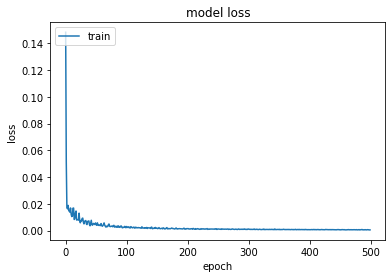

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.

(236, 40, 21)
(236, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 40, 512)           1093632   
_________________________________________________________________
dropout_9 (Dropout)          (None, 40, 512)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               328192    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
236/236 [==============================] - 3s 12ms/step - loss: 0.1490
Epoch 2/500
236/236 [====

236/236 [==============================] - 1s 2ms/step - loss: 0.0031
Epoch 88/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 89/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0032
Epoch 90/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 91/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0025
Epoch 92/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 93/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 94/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0040
Epoch 95/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0022
Epoch 96/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 97/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0025
Epoch 98/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 99/500
236/

236/236 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 185/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 186/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 187/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 188/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 189/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 190/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 191/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 192/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0020
Epoch 193/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 194/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 195/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 

236/236 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 281/500
236/236 [==============================] - 1s 2ms/step - loss: 8.1534e-04
Epoch 282/500
236/236 [==============================] - 1s 2ms/step - loss: 8.4768e-04
Epoch 283/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 284/500
236/236 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 285/500
236/236 [==============================] - 1s 2ms/step - loss: 9.0541e-04
Epoch 286/500
236/236 [==============================] - 1s 2ms/step - loss: 8.9854e-04
Epoch 287/500
236/236 [==============================] - 1s 2ms/step - loss: 8.5713e-04
Epoch 288/500
236/236 [==============================] - 0s 2ms/step - loss: 9.7057e-04
Epoch 289/500
236/236 [==============================] - 1s 2ms/step - loss: 8.4717e-04
Epoch 290/500
236/236 [==============================] - 1s 2ms/step - loss: 7.5172e-04
Epoch 291/500
236/236 [==============================] - 1

236/236 [==============================] - 1s 2ms/step - loss: 8.4508e-04
Epoch 374/500
236/236 [==============================] - 1s 2ms/step - loss: 7.0905e-04
Epoch 375/500
236/236 [==============================] - 1s 2ms/step - loss: 6.8638e-04
Epoch 376/500
236/236 [==============================] - 1s 2ms/step - loss: 6.5545e-04
Epoch 377/500
236/236 [==============================] - 1s 2ms/step - loss: 5.5678e-04
Epoch 378/500
236/236 [==============================] - 1s 2ms/step - loss: 6.4886e-04
Epoch 379/500
236/236 [==============================] - 1s 2ms/step - loss: 7.5852e-04
Epoch 380/500
236/236 [==============================] - 1s 2ms/step - loss: 7.3727e-04
Epoch 381/500
236/236 [==============================] - 1s 2ms/step - loss: 8.1730e-04
Epoch 382/500
236/236 [==============================] - 1s 2ms/step - loss: 5.8091e-04
Epoch 383/500
236/236 [==============================] - 1s 2ms/step - loss: 7.8330e-04
Epoch 384/500
236/236 [=======================

236/236 [==============================] - 1s 2ms/step - loss: 4.8830e-04
Epoch 467/500
236/236 [==============================] - 1s 2ms/step - loss: 5.3026e-04
Epoch 468/500
236/236 [==============================] - 1s 2ms/step - loss: 6.2966e-04
Epoch 469/500
236/236 [==============================] - 1s 2ms/step - loss: 5.1639e-04
Epoch 470/500
236/236 [==============================] - 1s 2ms/step - loss: 6.1891e-04
Epoch 471/500
236/236 [==============================] - 1s 2ms/step - loss: 5.9500e-04
Epoch 472/500
236/236 [==============================] - 1s 2ms/step - loss: 6.1176e-04
Epoch 473/500
236/236 [==============================] - 1s 2ms/step - loss: 6.5402e-04
Epoch 474/500
236/236 [==============================] - 1s 2ms/step - loss: 5.1171e-04
Epoch 475/500
236/236 [==============================] - 1s 2ms/step - loss: 4.5548e-04
Epoch 476/500
236/236 [==============================] - 1s 2ms/step - loss: 5.2562e-04
Epoch 477/500
236/236 [=======================

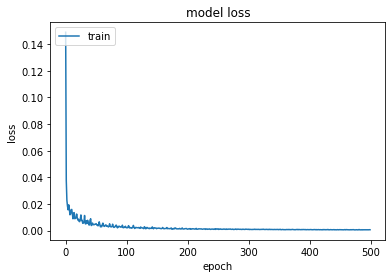

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.

(246, 50, 21)
(246, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50, 512)           1093632   
_________________________________________________________________
dropout_11 (Dropout)         (None, 50, 512)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               328192    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
246/246 [==============================] - 3s 13ms/step - loss: 0.1474
Epoch 2/500
246/246 [====

246/246 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 88/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 89/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 90/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 91/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 92/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 93/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 94/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 95/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 96/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 97/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 98/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 99/500
246/

246/246 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 185/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 186/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 187/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 188/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 189/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 190/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 191/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 192/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 193/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 194/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 195/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 

246/246 [==============================] - 1s 3ms/step - loss: 9.2744e-04
Epoch 281/500
246/246 [==============================] - 1s 3ms/step - loss: 9.1567e-04
Epoch 282/500
246/246 [==============================] - 1s 3ms/step - loss: 8.6293e-04A: 0s - loss: 9.2487e-0
Epoch 283/500
246/246 [==============================] - 1s 3ms/step - loss: 8.7133e-04
Epoch 284/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 285/500
246/246 [==============================] - 1s 3ms/step - loss: 9.3001e-04
Epoch 286/500
246/246 [==============================] - 1s 3ms/step - loss: 8.6202e-04
Epoch 287/500
246/246 [==============================] - 1s 3ms/step - loss: 8.6075e-04
Epoch 288/500
246/246 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 289/500
246/246 [==============================] - 1s 3ms/step - loss: 9.8791e-04
Epoch 290/500
246/246 [==============================] - 1s 3ms/step - loss: 8.4521e-04
Epoch 291/500
246/246 [========

246/246 [==============================] - 1s 3ms/step - loss: 6.3454e-04
Epoch 374/500
246/246 [==============================] - 1s 3ms/step - loss: 6.6259e-04
Epoch 375/500
246/246 [==============================] - 1s 3ms/step - loss: 6.5114e-04
Epoch 376/500
246/246 [==============================] - 1s 3ms/step - loss: 7.0060e-04
Epoch 377/500
246/246 [==============================] - 1s 3ms/step - loss: 6.0188e-04
Epoch 378/500
246/246 [==============================] - 1s 3ms/step - loss: 8.1951e-04
Epoch 379/500
246/246 [==============================] - 1s 3ms/step - loss: 5.8400e-04
Epoch 380/500
246/246 [==============================] - 1s 3ms/step - loss: 6.9579e-04
Epoch 381/500
246/246 [==============================] - 1s 3ms/step - loss: 6.5719e-04
Epoch 382/500
246/246 [==============================] - 1s 3ms/step - loss: 6.9354e-04
Epoch 383/500
246/246 [==============================] - 1s 3ms/step - loss: 6.7689e-04
Epoch 384/500
246/246 [=======================

246/246 [==============================] - 1s 3ms/step - loss: 5.2840e-04
Epoch 467/500
246/246 [==============================] - 1s 3ms/step - loss: 5.0773e-04
Epoch 468/500
246/246 [==============================] - 1s 3ms/step - loss: 5.1885e-04
Epoch 469/500
246/246 [==============================] - 1s 3ms/step - loss: 5.3716e-04
Epoch 470/500
246/246 [==============================] - 1s 3ms/step - loss: 5.5890e-04
Epoch 471/500
246/246 [==============================] - 1s 3ms/step - loss: 5.0425e-04
Epoch 472/500
246/246 [==============================] - 1s 3ms/step - loss: 5.9501e-04
Epoch 473/500
246/246 [==============================] - 1s 3ms/step - loss: 5.4763e-04
Epoch 474/500
246/246 [==============================] - 1s 3ms/step - loss: 4.9896e-04
Epoch 475/500
246/246 [==============================] - 1s 3ms/step - loss: 5.3188e-04
Epoch 476/500
246/246 [==============================] - 1s 3ms/step - loss: 5.2881e-04
Epoch 477/500
246/246 [=======================

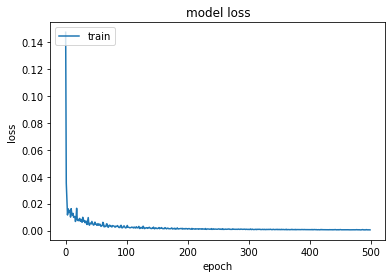

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.

(256, 60, 21)
(256, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 60, 512)           1093632   
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 512)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               328192    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
256/256 [==============================] - 3s 14ms/step - loss: 0.1572
Epoch 2/500
256/256 [====

256/256 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 88/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 89/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 90/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0027
Epoch 91/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 92/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 93/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 94/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0027
Epoch 95/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0018
Epoch 96/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 97/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 98/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 99/500
256/

256/256 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 185/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0017
Epoch 186/500
256/256 [==============================] - 1s 3ms/step - loss: 9.8048e-04
Epoch 187/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 188/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 189/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 190/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 191/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 192/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 193/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 194/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 195/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0011
Ep

Epoch 280/500
256/256 [==============================] - 1s 3ms/step - loss: 9.7321e-04
Epoch 281/500
256/256 [==============================] - 1s 3ms/step - loss: 8.5559e-04
Epoch 282/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 283/500
256/256 [==============================] - 1s 3ms/step - loss: 7.8421e-04
Epoch 284/500
256/256 [==============================] - 1s 3ms/step - loss: 8.4780e-04
Epoch 285/500
256/256 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 286/500
256/256 [==============================] - 1s 3ms/step - loss: 7.9794e-04
Epoch 287/500
256/256 [==============================] - 1s 3ms/step - loss: 8.1692e-04
Epoch 288/500
256/256 [==============================] - 1s 3ms/step - loss: 8.2660e-04
Epoch 289/500
256/256 [==============================] - 1s 3ms/step - loss: 9.2673e-04
Epoch 290/500
256/256 [==============================] - 1s 3ms/step - loss: 7.9545e-04
Epoch 291/500
256/256 [=================

256/256 [==============================] - 1s 3ms/step - loss: 6.7538e-04
Epoch 374/500
256/256 [==============================] - 1s 3ms/step - loss: 5.6784e-04
Epoch 375/500
256/256 [==============================] - 1s 3ms/step - loss: 6.5972e-04
Epoch 376/500
256/256 [==============================] - 1s 3ms/step - loss: 8.7551e-04
Epoch 377/500
256/256 [==============================] - 1s 3ms/step - loss: 6.8669e-04
Epoch 378/500
256/256 [==============================] - 1s 3ms/step - loss: 6.6332e-04
Epoch 379/500
256/256 [==============================] - 1s 3ms/step - loss: 7.0738e-04
Epoch 380/500
256/256 [==============================] - 1s 3ms/step - loss: 7.3678e-04
Epoch 381/500
256/256 [==============================] - 1s 3ms/step - loss: 6.8908e-04
Epoch 382/500
256/256 [==============================] - 1s 3ms/step - loss: 6.4647e-04
Epoch 383/500
256/256 [==============================] - 1s 3ms/step - loss: 6.6643e-04
Epoch 384/500
256/256 [=======================

256/256 [==============================] - 1s 3ms/step - loss: 5.6834e-04
Epoch 467/500
256/256 [==============================] - 1s 3ms/step - loss: 5.7175e-04
Epoch 468/500
256/256 [==============================] - 1s 3ms/step - loss: 5.5926e-04
Epoch 469/500
256/256 [==============================] - 1s 3ms/step - loss: 6.6457e-04
Epoch 470/500
256/256 [==============================] - 1s 3ms/step - loss: 5.0715e-04
Epoch 471/500
256/256 [==============================] - 1s 3ms/step - loss: 5.7962e-04
Epoch 472/500
256/256 [==============================] - 1s 3ms/step - loss: 5.4450e-04
Epoch 473/500
256/256 [==============================] - 1s 3ms/step - loss: 5.6893e-04
Epoch 474/500
256/256 [==============================] - 1s 3ms/step - loss: 5.3881e-04
Epoch 475/500
256/256 [==============================] - 1s 3ms/step - loss: 5.1987e-04
Epoch 476/500
256/256 [==============================] - 1s 3ms/step - loss: 5.4608e-04
Epoch 477/500
256/256 [=======================

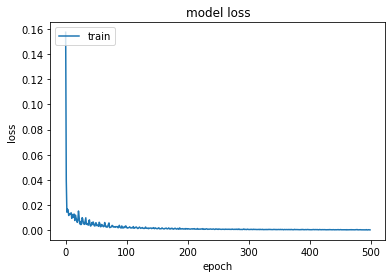

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.

(266, 70, 21)
(266, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 70, 512)           1093632   
_________________________________________________________________
dropout_15 (Dropout)         (None, 70, 512)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               328192    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
266/266 [==============================] - 4s 15ms/step - loss: 0.1588
Epoch 2/500
266/266 [====

266/266 [==============================] - 1s 5ms/step - loss: 0.0026
Epoch 88/500
266/266 [==============================] - 1s 5ms/step - loss: 0.0030
Epoch 89/500
266/266 [==============================] - 1s 4ms/step - loss: 0.0021
Epoch 90/500
266/266 [==============================] - 1s 5ms/step - loss: 0.0025
Epoch 91/500
266/266 [==============================] - 1s 5ms/step - loss: 0.0020
Epoch 92/500
266/266 [==============================] - 1s 4ms/step - loss: 0.0027
Epoch 93/500
266/266 [==============================] - 1s 5ms/step - loss: 0.0017
Epoch 94/500
266/266 [==============================] - 1s 4ms/step - loss: 0.0025
Epoch 95/500
266/266 [==============================] - 1s 4ms/step - loss: 0.0033
Epoch 96/500
266/266 [==============================] - 1s 5ms/step - loss: 0.0016
Epoch 97/500
266/266 [==============================] - 1s 4ms/step - loss: 0.0022
Epoch 98/500
266/266 [==============================] - 1s 5ms/step - loss: 0.0017
Epoch 99/500
266/

266/266 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 185/500
266/266 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 186/500
266/266 [==============================] - 1s 5ms/step - loss: 9.3952e-04
Epoch 187/500
266/266 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 188/500
266/266 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 189/500
266/266 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 190/500
266/266 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 191/500
266/266 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 192/500
266/266 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 193/500
266/266 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 194/500
266/266 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 195/500
266/266 [==============================] - 1s 5ms/step - loss: 0.0011
Ep

266/266 [==============================] - 1s 5ms/step - loss: 8.0559e-04
Epoch 279/500
266/266 [==============================] - 1s 4ms/step - loss: 7.6105e-04
Epoch 280/500
266/266 [==============================] - 1s 4ms/step - loss: 7.4129e-04
Epoch 281/500
266/266 [==============================] - 1s 4ms/step - loss: 7.2205e-04
Epoch 282/500
266/266 [==============================] - 1s 4ms/step - loss: 7.4055e-04
Epoch 283/500
266/266 [==============================] - 1s 4ms/step - loss: 8.2947e-04
Epoch 284/500
266/266 [==============================] - 1s 4ms/step - loss: 7.6373e-04
Epoch 285/500
266/266 [==============================] - 1s 4ms/step - loss: 7.6210e-04
Epoch 286/500
266/266 [==============================] - 1s 4ms/step - loss: 8.2286e-04
Epoch 287/500
266/266 [==============================] - 1s 5ms/step - loss: 7.0026e-04
Epoch 288/500
266/266 [==============================] - 1s 5ms/step - loss: 7.2055e-04
Epoch 289/500
266/266 [=======================

266/266 [==============================] - 1s 5ms/step - loss: 6.7997e-04
Epoch 372/500
266/266 [==============================] - 1s 5ms/step - loss: 5.5425e-04
Epoch 373/500
266/266 [==============================] - 1s 4ms/step - loss: 5.2963e-04
Epoch 374/500
266/266 [==============================] - 1s 4ms/step - loss: 5.5913e-04
Epoch 375/500
266/266 [==============================] - 1s 5ms/step - loss: 5.7248e-04
Epoch 376/500
266/266 [==============================] - 1s 4ms/step - loss: 7.4577e-04
Epoch 377/500
266/266 [==============================] - 1s 4ms/step - loss: 6.1232e-04
Epoch 378/500
266/266 [==============================] - 1s 5ms/step - loss: 5.8954e-04
Epoch 379/500
266/266 [==============================] - 1s 5ms/step - loss: 6.4439e-04
Epoch 380/500
266/266 [==============================] - 1s 5ms/step - loss: 5.9207e-04
Epoch 381/500
266/266 [==============================] - 1s 4ms/step - loss: 6.7795e-04
Epoch 382/500
266/266 [=======================

266/266 [==============================] - 1s 5ms/step - loss: 4.5398e-04
Epoch 465/500
266/266 [==============================] - 1s 4ms/step - loss: 4.5443e-04
Epoch 466/500
266/266 [==============================] - 1s 4ms/step - loss: 4.4755e-04
Epoch 467/500
266/266 [==============================] - 1s 4ms/step - loss: 4.4640e-04
Epoch 468/500
266/266 [==============================] - 1s 4ms/step - loss: 5.1454e-04
Epoch 469/500
266/266 [==============================] - 1s 4ms/step - loss: 4.9424e-04
Epoch 470/500
266/266 [==============================] - 1s 4ms/step - loss: 5.1514e-04
Epoch 471/500
266/266 [==============================] - 1s 4ms/step - loss: 4.6290e-04
Epoch 472/500
266/266 [==============================] - 1s 5ms/step - loss: 4.6728e-04
Epoch 473/500
266/266 [==============================] - 1s 5ms/step - loss: 4.5677e-04
Epoch 474/500
266/266 [==============================] - 1s 4ms/step - loss: 5.5498e-04
Epoch 475/500
266/266 [=======================

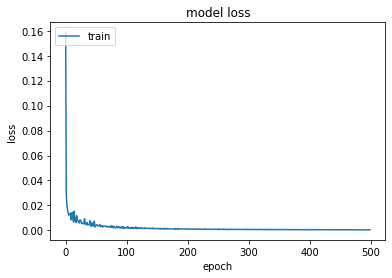

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.

(276, 80, 21)
(276, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 80, 512)           1093632   
_________________________________________________________________
dropout_17 (Dropout)         (None, 80, 512)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               328192    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
276/276 [==============================] - 4s 16ms/step - loss: 0.1629
Epoch 2/500
276/276 [====

276/276 [==============================] - 1s 5ms/step - loss: 0.0018
Epoch 88/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0020
Epoch 89/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0036
Epoch 90/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0022
Epoch 91/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0020
Epoch 92/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0024
Epoch 93/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0029
Epoch 94/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0021
Epoch 95/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0019
Epoch 96/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0028
Epoch 97/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0019
Epoch 98/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0018
Epoch 99/500
276/

276/276 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 185/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 186/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 187/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 188/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 189/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 190/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 191/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 192/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 193/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 194/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 195/500
276/276 [==============================] - 1s 5ms/step - loss: 0.0010
Epoch 

276/276 [==============================] - 1s 5ms/step - loss: 7.9853e-04
Epoch 279/500
276/276 [==============================] - 1s 5ms/step - loss: 8.0249e-04
Epoch 280/500
276/276 [==============================] - 1s 5ms/step - loss: 6.6471e-04
Epoch 281/500
276/276 [==============================] - 1s 5ms/step - loss: 8.3527e-04
Epoch 282/500
276/276 [==============================] - 1s 5ms/step - loss: 6.3867e-04
Epoch 283/500
276/276 [==============================] - 1s 5ms/step - loss: 9.2033e-04
Epoch 284/500
276/276 [==============================] - 1s 5ms/step - loss: 7.7445e-04
Epoch 285/500
276/276 [==============================] - 1s 5ms/step - loss: 7.4477e-04
Epoch 286/500
276/276 [==============================] - 1s 5ms/step - loss: 7.0564e-04
Epoch 287/500
276/276 [==============================] - 2s 6ms/step - loss: 8.1419e-04
Epoch 288/500
276/276 [==============================] - 2s 6ms/step - loss: 7.2671e-04
Epoch 289/500
276/276 [=======================

276/276 [==============================] - 1s 5ms/step - loss: 6.0666e-04
Epoch 372/500
276/276 [==============================] - 1s 5ms/step - loss: 6.4300e-04
Epoch 373/500
276/276 [==============================] - 1s 5ms/step - loss: 5.6419e-04
Epoch 374/500
276/276 [==============================] - 1s 5ms/step - loss: 5.3545e-04
Epoch 375/500
276/276 [==============================] - 1s 5ms/step - loss: 6.2531e-04
Epoch 376/500
276/276 [==============================] - 1s 5ms/step - loss: 6.7265e-04
Epoch 377/500
276/276 [==============================] - 1s 5ms/step - loss: 5.8435e-04
Epoch 378/500
276/276 [==============================] - 1s 5ms/step - loss: 5.8390e-04
Epoch 379/500
276/276 [==============================] - 1s 5ms/step - loss: 5.7382e-04
Epoch 380/500
276/276 [==============================] - 1s 5ms/step - loss: 5.0532e-04
Epoch 381/500
276/276 [==============================] - 1s 5ms/step - loss: 6.1148e-04
Epoch 382/500
276/276 [=======================

276/276 [==============================] - 1s 5ms/step - loss: 4.1673e-04
Epoch 465/500
276/276 [==============================] - 1s 5ms/step - loss: 4.3992e-04
Epoch 466/500
276/276 [==============================] - 1s 5ms/step - loss: 5.5388e-04
Epoch 467/500
276/276 [==============================] - 2s 5ms/step - loss: 4.6350e-04
Epoch 468/500
276/276 [==============================] - 1s 5ms/step - loss: 4.7100e-04
Epoch 469/500
276/276 [==============================] - 1s 5ms/step - loss: 4.3913e-04
Epoch 470/500
276/276 [==============================] - 1s 5ms/step - loss: 4.6150e-04
Epoch 471/500
276/276 [==============================] - 1s 5ms/step - loss: 4.8736e-04
Epoch 472/500
276/276 [==============================] - 1s 5ms/step - loss: 4.4694e-04
Epoch 473/500
276/276 [==============================] - 1s 5ms/step - loss: 4.7024e-04
Epoch 474/500
276/276 [==============================] - 1s 5ms/step - loss: 5.5696e-04
Epoch 475/500
276/276 [=======================

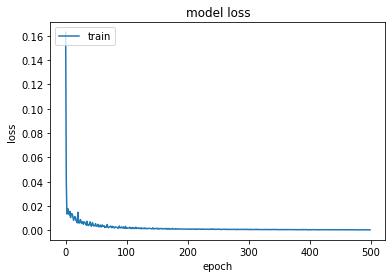

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.

[375 rows x 16 columns]
<class 'pandas.core.frame.DataFrame'>
(375, 16)
(286, 90, 21)
(286, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 90, 512)           1093632   
_________________________________________________________________
dropout_19 (Dropout)         (None, 90, 512)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               328192    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
286/286 [===============

286/286 [==============================] - 2s 6ms/step - loss: 0.0025
Epoch 87/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0022
Epoch 88/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0018
Epoch 89/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0027
Epoch 90/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0031
Epoch 91/500
286/286 [==============================] - 2s 5ms/step - loss: 0.0018
Epoch 92/500
286/286 [==============================] - 2s 5ms/step - loss: 0.0019
Epoch 93/500
286/286 [==============================] - 1s 5ms/step - loss: 0.0023
Epoch 94/500
286/286 [==============================] - 2s 5ms/step - loss: 0.0024
Epoch 95/500
286/286 [==============================] - 2s 5ms/step - loss: 0.0018
Epoch 96/500
286/286 [==============================] - 2s 5ms/step - loss: 0.0022
Epoch 97/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0015
Epoch 98/500
286/

286/286 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 184/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0010
Epoch 185/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0012
Epoch 186/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 187/500
286/286 [==============================] - 2s 6ms/step - loss: 8.2065e-04
Epoch 188/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0012
Epoch 189/500
286/286 [==============================] - 2s 5ms/step - loss: 0.0010
Epoch 190/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0012
Epoch 191/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0010
Epoch 192/500
286/286 [==============================] - 2s 6ms/step - loss: 9.7803e-04
Epoch 193/500
286/286 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 194/500
286/286 [==============================] - 2s 6ms/step - loss: 9.852

286/286 [==============================] - 2s 6ms/step - loss: 6.5022e-04
Epoch 278/500
286/286 [==============================] - 2s 6ms/step - loss: 6.5199e-04
Epoch 279/500
286/286 [==============================] - 2s 6ms/step - loss: 7.4620e-04
Epoch 280/500
286/286 [==============================] - 2s 6ms/step - loss: 7.5279e-04
Epoch 281/500
286/286 [==============================] - 2s 6ms/step - loss: 6.6386e-04
Epoch 282/500
286/286 [==============================] - 2s 6ms/step - loss: 8.1743e-04
Epoch 283/500
286/286 [==============================] - 2s 6ms/step - loss: 8.1707e-04
Epoch 284/500
286/286 [==============================] - 2s 5ms/step - loss: 6.8321e-04
Epoch 285/500
286/286 [==============================] - 2s 6ms/step - loss: 7.8633e-04
Epoch 286/500
286/286 [==============================] - 2s 6ms/step - loss: 7.2301e-04
Epoch 287/500
286/286 [==============================] - 2s 6ms/step - loss: 8.0389e-04
Epoch 288/500
286/286 [=======================

286/286 [==============================] - 2s 6ms/step - loss: 5.2504e-04
Epoch 371/500
286/286 [==============================] - 2s 6ms/step - loss: 6.0132e-04
Epoch 372/500
286/286 [==============================] - 2s 6ms/step - loss: 6.0030e-04
Epoch 373/500
286/286 [==============================] - 2s 5ms/step - loss: 6.2662e-04
Epoch 374/500
286/286 [==============================] - 2s 6ms/step - loss: 6.0160e-04
Epoch 375/500
286/286 [==============================] - 2s 5ms/step - loss: 5.1530e-04
Epoch 376/500
286/286 [==============================] - 2s 6ms/step - loss: 5.3098e-04
Epoch 377/500
286/286 [==============================] - 2s 6ms/step - loss: 5.8198e-04
Epoch 378/500
286/286 [==============================] - 2s 6ms/step - loss: 5.0339e-04
Epoch 379/500
286/286 [==============================] - 2s 6ms/step - loss: 5.0751e-04
Epoch 380/500
286/286 [==============================] - 2s 6ms/step - loss: 5.9739e-04
Epoch 381/500
286/286 [=======================

286/286 [==============================] - 2s 5ms/step - loss: 4.5835e-04
Epoch 464/500
286/286 [==============================] - 2s 6ms/step - loss: 9.8184e-04
Epoch 465/500
286/286 [==============================] - 2s 6ms/step - loss: 4.9378e-04
Epoch 466/500
286/286 [==============================] - 2s 6ms/step - loss: 4.0387e-04
Epoch 467/500
286/286 [==============================] - 2s 6ms/step - loss: 4.3583e-04
Epoch 468/500
286/286 [==============================] - 2s 6ms/step - loss: 4.2116e-04
Epoch 469/500
286/286 [==============================] - 2s 6ms/step - loss: 4.0558e-04
Epoch 470/500
286/286 [==============================] - 2s 6ms/step - loss: 4.4140e-04
Epoch 471/500
286/286 [==============================] - 2s 6ms/step - loss: 4.2719e-04
Epoch 472/500
286/286 [==============================] - 2s 6ms/step - loss: 4.3497e-04
Epoch 473/500
286/286 [==============================] - 2s 6ms/step - loss: 5.3327e-04
Epoch 474/500
286/286 [=======================

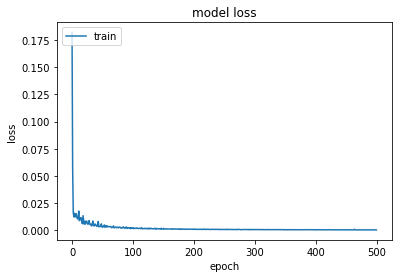

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.

[395 rows x 16 columns]
<class 'pandas.core.frame.DataFrame'>
(395, 16)
(296, 100, 21)
(296, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 100, 512)          1093632   
_________________________________________________________________
dropout_21 (Dropout)         (None, 100, 512)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               328192    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
296/296 [==============

296/296 [==============================] - 2s 6ms/step - loss: 0.0026
Epoch 87/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0020
Epoch 88/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0019
Epoch 89/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0019
Epoch 90/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0023
Epoch 91/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0035
Epoch 92/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0018
Epoch 93/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0018
Epoch 94/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0023
Epoch 95/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 96/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0030
Epoch 97/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0016
Epoch 98/500
296/

296/296 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 184/500
296/296 [==============================] - 2s 6ms/step - loss: 8.9285e-04
Epoch 185/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0013
Epoch 186/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0012
Epoch 187/500
296/296 [==============================] - 2s 6ms/step - loss: 9.7101e-04
Epoch 188/500
296/296 [==============================] - 2s 6ms/step - loss: 9.4590e-04
Epoch 189/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0012
Epoch 190/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0010
Epoch 191/500
296/296 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 192/500
296/296 [==============================] - 2s 6ms/step - loss: 9.6160e-04
Epoch 193/500
296/296 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 194/500
296/296 [==============================] - 2s 6ms/step - los

296/296 [==============================] - 2s 6ms/step - loss: 7.6382e-04
Epoch 278/500
296/296 [==============================] - 2s 6ms/step - loss: 7.3090e-04
Epoch 279/500
296/296 [==============================] - 2s 6ms/step - loss: 7.3477e-04
Epoch 280/500
296/296 [==============================] - 2s 6ms/step - loss: 8.3722e-04
Epoch 281/500
296/296 [==============================] - 2s 6ms/step - loss: 8.2388e-04
Epoch 282/500
296/296 [==============================] - 2s 6ms/step - loss: 5.8569e-04
Epoch 283/500
296/296 [==============================] - 2s 6ms/step - loss: 7.7381e-04
Epoch 284/500
296/296 [==============================] - 2s 6ms/step - loss: 7.0938e-04
Epoch 285/500
296/296 [==============================] - 2s 6ms/step - loss: 6.6975e-04
Epoch 286/500
296/296 [==============================] - 2s 6ms/step - loss: 7.3098e-04
Epoch 287/500
296/296 [==============================] - 2s 6ms/step - loss: 7.5620e-04
Epoch 288/500
296/296 [=======================

296/296 [==============================] - 2s 6ms/step - loss: 6.0989e-04
Epoch 371/500
296/296 [==============================] - 2s 6ms/step - loss: 5.2320e-04
Epoch 372/500
296/296 [==============================] - 2s 6ms/step - loss: 5.7928e-04
Epoch 373/500
296/296 [==============================] - 2s 6ms/step - loss: 4.9869e-04
Epoch 374/500
296/296 [==============================] - 2s 6ms/step - loss: 6.2919e-04
Epoch 375/500
296/296 [==============================] - 2s 6ms/step - loss: 6.2593e-04
Epoch 376/500
296/296 [==============================] - 2s 6ms/step - loss: 5.5048e-04
Epoch 377/500
296/296 [==============================] - 2s 6ms/step - loss: 5.3490e-04
Epoch 378/500
296/296 [==============================] - 2s 6ms/step - loss: 5.3348e-04
Epoch 379/500
296/296 [==============================] - 2s 6ms/step - loss: 5.5231e-04
Epoch 380/500
296/296 [==============================] - 2s 6ms/step - loss: 4.8115e-04
Epoch 381/500
296/296 [=======================

296/296 [==============================] - 2s 6ms/step - loss: 4.2356e-04
Epoch 464/500
296/296 [==============================] - 2s 6ms/step - loss: 4.9780e-04
Epoch 465/500
296/296 [==============================] - 2s 6ms/step - loss: 3.9923e-04
Epoch 466/500
296/296 [==============================] - 2s 6ms/step - loss: 4.1084e-04
Epoch 467/500
296/296 [==============================] - 2s 7ms/step - loss: 4.7366e-04
Epoch 468/500
296/296 [==============================] - 2s 6ms/step - loss: 4.9442e-04
Epoch 469/500
296/296 [==============================] - 2s 6ms/step - loss: 4.3675e-04
Epoch 470/500
296/296 [==============================] - 2s 6ms/step - loss: 4.5039e-04
Epoch 471/500
296/296 [==============================] - 2s 6ms/step - loss: 4.2133e-04
Epoch 472/500
296/296 [==============================] - 2s 6ms/step - loss: 3.7013e-04
Epoch 473/500
296/296 [==============================] - 2s 6ms/step - loss: 4.0597e-04
Epoch 474/500
296/296 [=======================

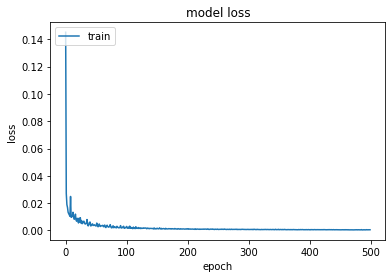

datasets_full_trag/actions/0_actions.csv
datasets_full_trag/obs/0_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.359866e-07  0.500000  0.500008   
1    0.747437  0.496399   0.495675  1.559631e-02  0.502802  0.497695   
2    0.744713  0.494445   0.495420  3.108582e-02  0.504518  0.499768   
3    0.736751  0.487599   0.499852  6.292728e-02  0.503982  0.501506   
4    0.728789  0.479638   0.504053  9.477040e-02  0.502533  0.506107   
5    0.720826  0.472231   0.510485  1.266141e-01  0.498753  0.510172   
6    0.712864  0.469651   0.514839  1.584595e-01  0.499176  0.510852   
7    0.704902  0.467935   0.516326  1.903042e-01  0.502580  0.512479   
8    0.696940  0.466904   0.515886  2.221487e-01  0.505730  0.510053   
9    0.688978  0.465807   0.513335  2.539928e-01  0.508656  0.506144   
10   0.681015  0.465379   0.510847  2.858373e-01  0.509966  0.503302   
11   0.673053  0.465424   0.509558  3.176820e-01  0.509489  0.

[415 rows x 37 columns]
~~~~~~~~~~~~~~~~~~normalize finish~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
     act_arm_one  act_arm_two  act_arm_three  act_arm_four  act_arm_five  \
0       0.747437     0.496399       0.495675      0.015596      0.502802   
1       0.747437     0.496399       0.495675      0.015596      0.502802   
2       0.747437     0.496399       0.495675      0.015596      0.502802   
3       0.747437     0.496399       0.495675      0.015596      0.502802   
4       0.747437     0.496399       0.495675      0.015596      0.502802   
5       0.747437     0.496399       0.495675      0.015596      0.502802   
6       0.747437     0.496399       0.495675      0.015596      0.502802   
7       0.747437     0.496399       0.495675      0.015596      0.502802   
8       0.747437     0.496399       0.495675      0.015596      0.502802   
9       0.747437     0.496399       0.495675      0.015596      0.502802   
10      0.747437     0.496399       0.495675

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 110, 512)          1093632   
_________________________________________________________________
dropout_23 (Dropout)         (None, 110, 512)          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 128)               328192    
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                2064      
Total params: 1,423,888
Trainable params: 1,423,888
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
306/306 [==============================] - 6s 18ms/step - loss: 0.1424
Epoch 2/500
306/306 [============================

306/306 [==============================] - 2s 7ms/step - loss: 0.0021
Epoch 88/500
306/306 [==============================] - 2s 6ms/step - loss: 0.0026
Epoch 89/500
306/306 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 90/500
306/306 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 91/500
306/306 [==============================] - 2s 6ms/step - loss: 0.0023
Epoch 92/500
306/306 [==============================] - 2s 6ms/step - loss: 0.0019
Epoch 93/500
306/306 [==============================] - 2s 6ms/step - loss: 0.0024
Epoch 94/500
306/306 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 95/500
306/306 [==============================] - 2s 7ms/step - loss: 0.0019
Epoch 96/500
306/306 [==============================] - 2s 6ms/step - loss: 0.0018
Epoch 97/500
306/306 [==============================] - 2s 6ms/step - loss: 0.0028
Epoch 98/500
306/306 [==============================] - 2s 6ms/step - loss: 0.0018
Epoch 99/500
306/

In [ ]:
# ####################single training single dataset####################################
if __name__ == '__main__':
    
    
    all_filenames = []
    trag_pos = 0
#     timesteps = 5
    experiment_index = 0
    
    while(experiment_index < 16):
        if(experiment_index == 0):
            timesteps = 5
        elif(experiment_index == 1):
            timesteps = 10
        elif(experiment_index == 2):
            timesteps = 20
        elif(experiment_index == 3):
            timesteps = 30
        elif(experiment_index == 4):
            timesteps = 40
        elif(experiment_index == 5):
            timesteps = 50
        elif(experiment_index == 6):
            timesteps = 60
        elif(experiment_index == 7):
            timesteps = 70
        elif(experiment_index == 8):
            timesteps = 80
        elif(experiment_index == 9):
            timesteps = 90
        elif(experiment_index == 10):
            timesteps = 100
        elif(experiment_index == 11):
            timesteps = 110
#         elif(experiment_index == 12):
#             timesteps = 120
#         elif(experiment_index == 13):
#             timesteps = 130
#         elif(experiment_index == 14):
#             timesteps = 140
#         elif(experiment_index == 15):
#             timesteps = 150
            
        experiment_index = experiment_index + 1
        
        filename = "datasets_full_trag/npz/Lstm-syn-dataset-fulltrag-addcoke/Lstm0_position.npz"
        data = np.load(filename)
        actions_val = None
        obs_val = None

        for key, value in data.items():
            if(key == "actions"):
                actions_val = value
            elif(key == "obs"):
                obs_val = value

        action_path = generate_csv(actions_val, "actions", "datasets_full_trag/actions/0_actions.csv")
        obs_path = generate_csv(obs_val, "obs", "datasets_full_trag/obs/0_obs.csv")
        print(action_path)
        print(obs_path)
        merge_csv(obs_path, action_path, "datasets_full_trag/merge/0_dataset.csv")
        train = readTrain("datasets_full_trag/merge/0_dataset.csv")
        

        #augment data
        aug_train = augDataRow(train, timesteps)
        print("~~~~~~~~~~~~~~~~~~augmented finish~~~~~~~~~~~~~~~~~~~~~~~")

        # Normalization
        train_norm = normalize(aug_train)
        print(train_norm)
        print("~~~~~~~~~~~~~~~~~~normalize finish~~~~~~~~~~~~~~~~~~~~~~~")

        X_train, Y_train = buildTrain_v2(train_norm, timesteps)


        print(X_train.shape)
        print(Y_train.shape)
        ### shuffle the data, and random seed is 10
        X_train, Y_train = shuffle(X_train, Y_train)

    # # # #     # split training data and validation data
    # # # #     X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.2)


#         model = buildManyToOneModel(X_train)
        model = buildManyToOneModel_expand_depth(X_train)
        callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
#         model.fit(X_train, Y_train, epochs=500, batch_size=64)
        history = model.fit(X_train, Y_train, epochs=500, batch_size=64)
    
        plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper left')
        plt.legend(['train'], loc='upper left')
        
        save_lossPic_path = "model_expand_depth/full_trag/512_128_ver/batch_size_64/Loss/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".png"
        plt.savefig(save_lossPic_path)
        
        plt.show()
    # # # model.fit(X_train, Y_train, epochs=200, batch_size=32, callbacks=[callback])
    # # # model.fit(X_train, Y_train, epochs=200, batch_size=16, validation_data=(X_val, Y_val), callbacks=[callback])


        save_path = "model_expand_depth/full_trag/512_128_ver/batch_size_64/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".h5"
        
        model.save(save_path)  # creates a HDF5 file

    
        del model
    
    print("training done")

